# Notebook for studying edge roll off

Sean M., 01-17-25

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import sys
sys.path.append('/home/s/seanmacb/Camera/DefectAnalysis')
import run_six_utils as rsu
sys.path.append('/home/s/seanmacb/Camera/pkgs')
sys.path.append('/home/s/seanmacb/Camera/pkgs/eo_pipe/python/lsst/eo/pipe')
import eo_pipe.python.lsst.eo.pipe as eo_pipe
from eo_pipe.python.lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask, eperTask, divisaderoTearingTask, ptcPlotsTask,linearityPlotsTask, bfAnalysisTask)
import copy
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
plt.style.use("seaborn-v0_8-talk")
from matplotlib import lines
from mpl_toolkits import axes_grid1
from astropy.stats import sigma_clip
from scipy.stats import skew
from tabulate import tabulate
from scipy.stats import norm

from lsst.obs.lsst import LsstCam, LsstTS8
from IPython.display import display_html, HTML
import myutils_ar.myutils as myu
from importlib import reload

In [2]:
r7Butler = daf_butler.Butler("embargo_new",collections='u/lsstccs/flat_E1880_w_2024_35')

In [3]:
typeMask = [myu.det_ptypes[myu.det_nums[x]] for x in myu.det_nums.keys()]
E2VnumBoo = [x=="E2V" for x in typeMask]
ITLnumBoo = [x=="ITL" for x in typeMask]
E2Vnums, ITLnums = [],[]
for k in range(205):
    if E2VnumBoo[k]:
        E2Vnums.append(k)
    elif ITLnumBoo[k]:
        ITLnums.append(k)

# Let's do this for the w_2024_35 weekly first

## ITL detectors first

In [4]:
ITLnormflats = []
for num in ITLnums:
    exp = r7Butler.get(list(r7Butler.registry.queryDatasets("flat",where="instrument='LSSTCam' and detector={}".format(num)))[0])
    ITLnormflats.append([np.median(exp.image.array/np.median(exp.image.array),axis=0),np.median(exp.image.array/np.median(exp.image.array),axis=1)])

In [5]:
superNormArr_0 = np.zeros(np.shape(ITLnormflats[0][0]))
superNormArr_1 = np.zeros(np.shape(ITLnormflats[0][1]))
for i,arr in zip(range(2),[superNormArr_0,superNormArr_1]):
    for entry in ITLnormflats:
        arr+=entry[i]
    arr/=len(ITLnormflats)

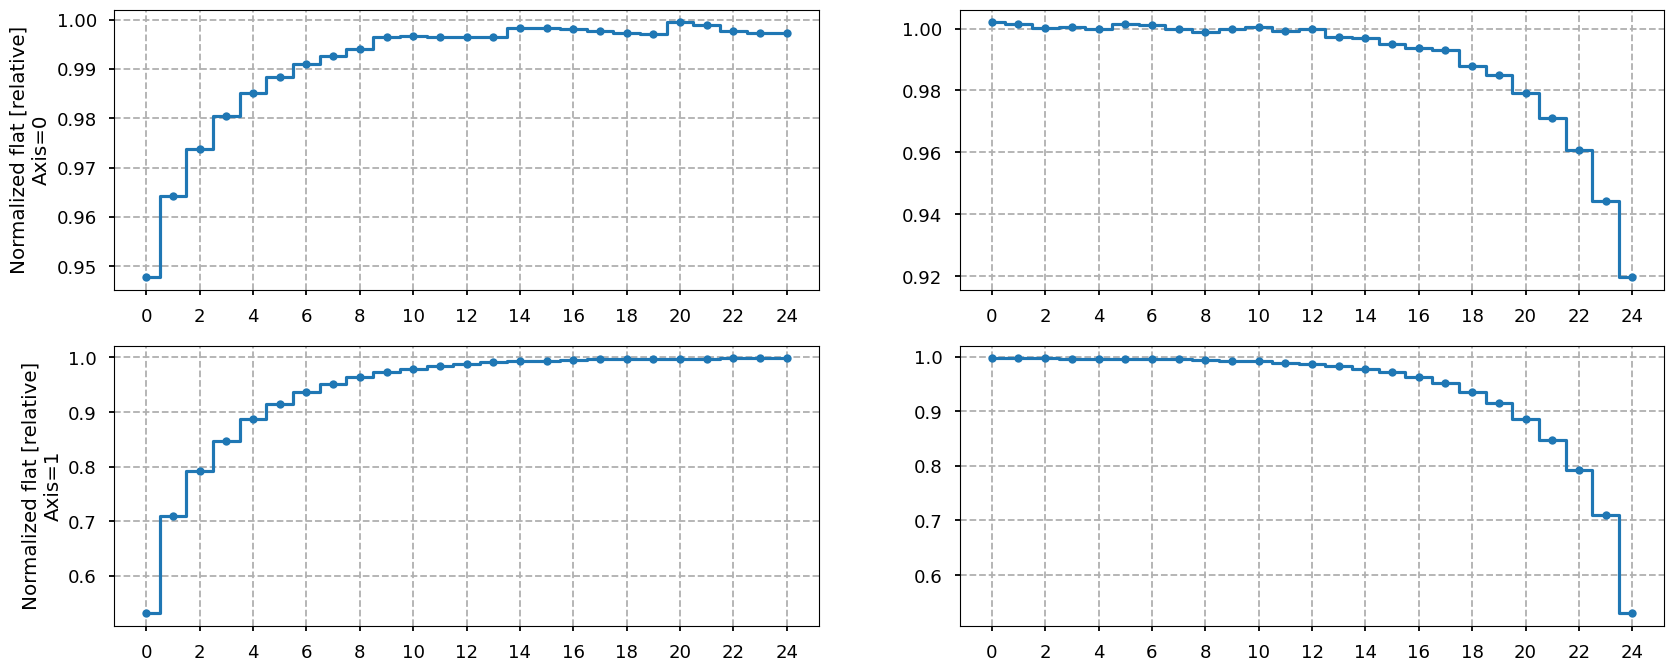

In [6]:
fig,axs = plt.subplots(2,2,figsize=[20,8])

window=25

for edgeArr,ax,counter in zip([superNormArr_0,superNormArr_1],axs,range(2)):
    # print(counter)
    if counter < 1:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=0")
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        ax[0].step(np.arange(window),edgeArr[:window:]/normVal1,'-o',where='mid',markersize=6)
        ax[1].step(np.arange(window),edgeArr[-window::]/normVal2,'-o',where='mid',markersize=6)
        
    else:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=1")
        # No amplifier adjustment

        ax[0].step(np.arange(0,window),edgeArr[:window:],'-o',where='mid',markersize=6)
        ax[1].step(np.arange(0,window),edgeArr[-window::],'-o',where='mid',markersize=6)
    
    
for ax in axs.flatten():
    ax.grid(ls='--')
    # ax.set_ylim(0.95,1)

for ax in axs[1,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))

for ax in axs[0,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))
    # ax.set_ylim(0.95,1.03)


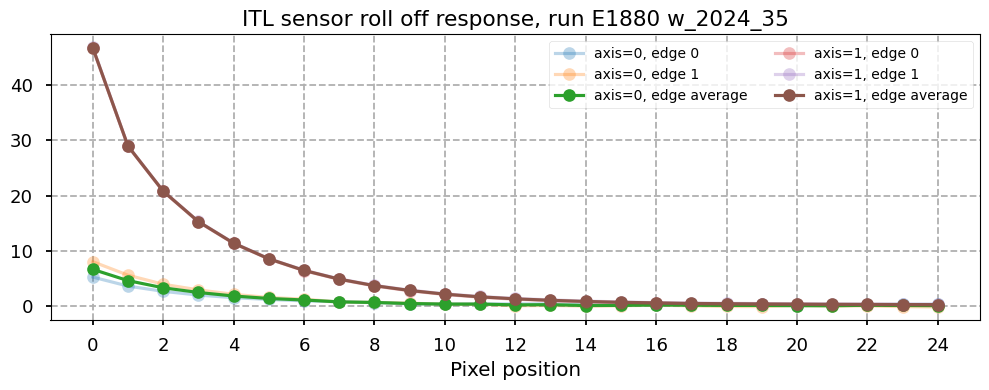

In [7]:
fig,ax = plt.subplots(figsize=[10,4])

window=25

for edgeArr,counter in zip([superNormArr_0,superNormArr_1],range(2)):
    if counter < 1:
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        edge1 = edgeArr[:window:]/normVal1
        edge2 = edgeArr[-window::][::-1]/normVal2

        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,'-o',label="axis=0, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,'-o',label="axis=0, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,'-o',label="axis=0, edge average")
        
        outArr0 = (1-edges)*100
    else:
        # No amplifier adjustment

        edge1 = edgeArr[:window:]
        edge2 = edgeArr[-window::][::-1]
        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,"-o",label="axis=1, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,"-o",label="axis=1, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,"-o",label="axis=1, edge average")
        
        outArr1 = (1-edges)*100
ax.grid(ls='--')
ax.legend(fontsize='medium',ncols=2)

ax.set_xticks(np.arange(0,window+1,step=2))
ax.set_xlabel("Pixel position")

# ax.set_ylim(0,3)
# ax.set_ylim(0,1.75)

ax.set_title("ITL sensor roll off response, run E1880 w_2024_35")

fig.tight_layout()

fig.show()

In [8]:
minimizeArray = ((outArr0[:19]+outArr1[:19][::-1])/2)
minInd0 = np.argmin(minimizeArray, axis=0)
minInd1 = 9+(9-minInd0)
print("Optimal configuration to minimize flat field edge fluctuation: {} on ax_0, {} on ax_1".format(minInd0,minInd1))
print("Edge roll off fluctuation: {:2.2f}, {:2.2f}, average {:2.2f}".format(outArr0[minInd0],outArr1[minInd1], np.mean([outArr0[minInd0],outArr1[minInd1]])))

Optimal configuration to minimize flat field edge fluctuation: 6 on ax_0, 12 on ax_1
Edge roll off fluctuation: 1.06, 1.27, average 1.17


Text(0, 0.5, 'Normalized flat [relative]\nAxis=1')

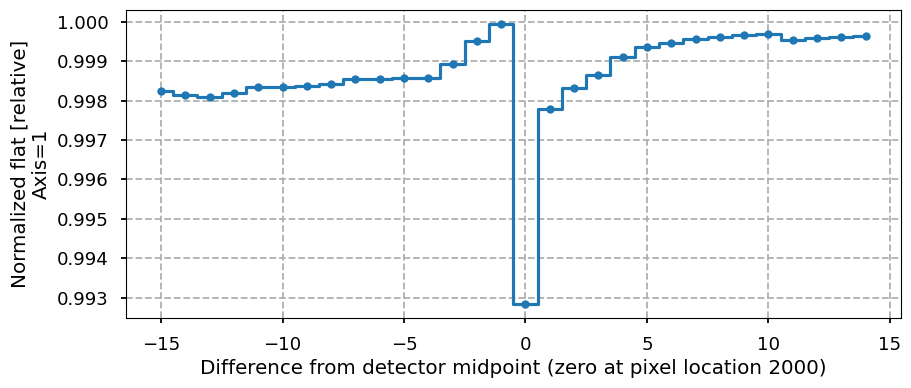

In [9]:
fig,ax = plt.subplots(figsize=[10,4],sharex=True)

window = 15

midpoint = int(len(superNormArr_1)/2)
midArray = edgeArr[midpoint-window:midpoint+window]
ax.step(np.arange(len(midArray))-window,midArray,'-o',where='mid',markersize=6)
ax.grid(ls='--')

ax.set_xlabel("Difference from detector midpoint (zero at pixel location {})".format(midpoint))
ax.set_ylabel("Normalized flat [relative]\nAxis=1")

### From the above, we know the following
- Axis=1 records the mid-line break, so that is taking slices of y in detector space
- Roll off response for y detector space is very strong - the dominant source of roll off for ITL sensors
- Flat field fluctuation is minimized for a border configuration of 5-7 pixels on axis=0 (left/right) and 11-13 pixels on axis=1 (up/down)
    - 5/13: 0.71612334, 1.63002801 -> 1.173 avg
    - 6/12: 1.06037031, 1.26993789 -> 1.165 avg
    - 7/11: 1.33505374, 1.00471568 -> 1.170 avg
- So the 6/12 configuration performs the best, but only by a tiny margin. The other configurations provide very similar results
- Mid line break impact is ≤1% relative

## E2V detectors now

In [10]:
E2Vnormflats = []
for num in E2Vnums:
    exp = r7Butler.get(list(r7Butler.registry.queryDatasets("flat",where="instrument='LSSTCam' and detector={}".format(num)))[0])
    E2Vnormflats.append([np.median(exp.image.array/np.median(exp.image.array),axis=0),np.median(exp.image.array/np.median(exp.image.array),axis=1)])

In [11]:
superNormArr_0 = np.zeros(np.shape(E2Vnormflats[0][0]))
superNormArr_1 = np.zeros(np.shape(E2Vnormflats[0][1]))
for i,arr in zip(range(2),[superNormArr_0,superNormArr_1]):
    for entry in E2Vnormflats:
        arr+=entry[i]
    arr/=len(E2Vnormflats)

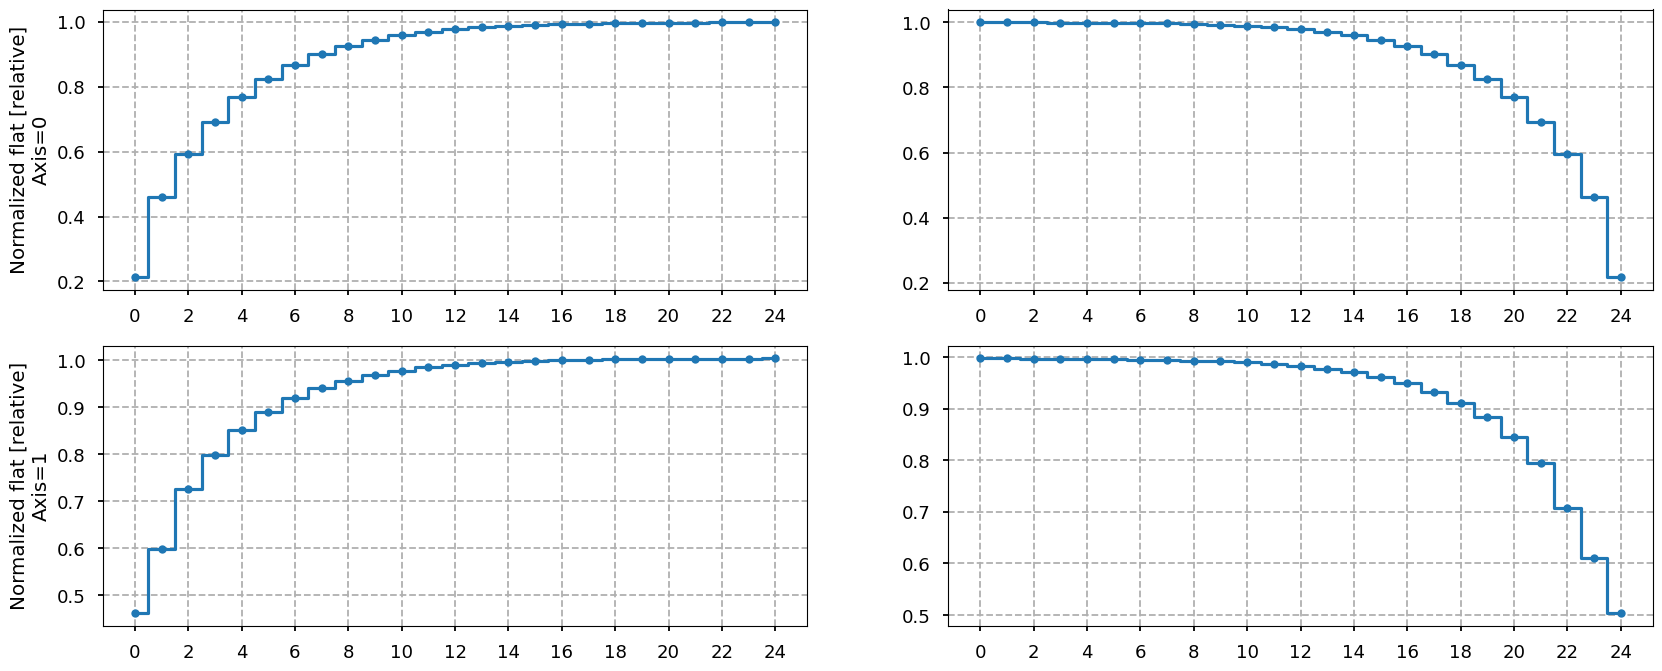

In [12]:
fig,axs = plt.subplots(2,2,figsize=[20,8])

window=25

for edgeArr,ax,counter in zip([superNormArr_0,superNormArr_1],axs,range(2)):
    # print(counter)
    if counter < 1:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=0")
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        ax[0].step(np.arange(window),edgeArr[:window:]/normVal1,'-o',where='mid',markersize=6)
        ax[1].step(np.arange(window),edgeArr[-window::]/normVal2,'-o',where='mid',markersize=6)
        
    else:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=1")
        # No amplifier adjustment

        ax[0].step(np.arange(0,window),edgeArr[:window:],'-o',where='mid',markersize=6)
        ax[1].step(np.arange(0,window),edgeArr[-window::],'-o',where='mid',markersize=6)
    
    
for ax in axs.flatten():
    ax.grid(ls='--')
    # ax.set_ylim(0.95,1)

for ax in axs[1,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))

for ax in axs[0,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))
    # ax.set_ylim(0.95,1.03)


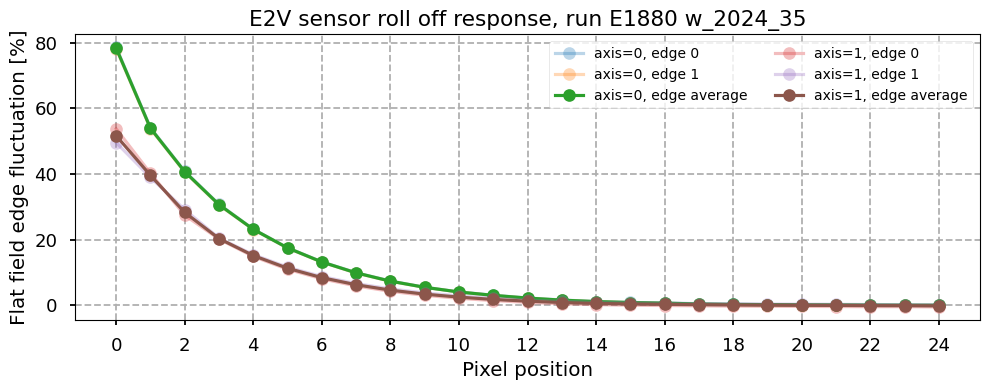

In [13]:
fig,ax = plt.subplots(figsize=[10,4])

window=25

for edgeArr,counter in zip([superNormArr_0,superNormArr_1],range(2)):
    if counter < 1:
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        edge1 = edgeArr[:window:]/normVal1
        edge2 = edgeArr[-window::][::-1]/normVal2

        edges = (edge1 + edge2) / 2

        # print((1-edges[5:8])[::-1]*100)

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,'-o',label="axis=0, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,'-o',label="axis=0, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,'-o',label="axis=0, edge average")
        outArr0 = (1-edges)*100
    else:
        # No amplifier adjustment

        edge1 = edgeArr[:window:]
        edge2 = edgeArr[-window::][::-1]
        edges = (edge1 + edge2) / 2


        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,"-o",label="axis=1, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,"-o",label="axis=1, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,"-o",label="axis=1, edge average")
        outArr1 = (1-edges)*100
    
ax.grid(ls='--')
ax.legend(fontsize='medium',ncols=2)

ax.set_ylabel("Flat field edge fluctuation [%]")
ax.set_xticks(np.arange(0,window+1,step=2))
ax.set_xlabel("Pixel position")

ax.set_title("E2V sensor roll off response, run E1880 w_2024_35")

fig.tight_layout()

fig.show()

In [14]:
minimizeArray = ((outArr0[:19]+outArr1[:19][::-1])/2)
minInd0 = np.argmin(minimizeArray, axis=0)
minInd1 = 9+(9-minInd0)
print("Optimal configuration to minimize flat field edge fluctuation: {} on ax_0, {} on ax_1".format(minInd0,minInd1))
print("Edge roll off fluctuation: {:2.2f}, {:2.2f}, average {:2.2f}".format(outArr0[minInd0],outArr1[minInd1], np.mean([outArr0[minInd0],outArr1[minInd1]])))

Optimal configuration to minimize flat field edge fluctuation: 10 on ax_0, 8 on ax_1
Edge roll off fluctuation: 4.10, 4.68, average 4.39


Text(0, 0.5, 'Normalized flat [relative]\nAxis=1')

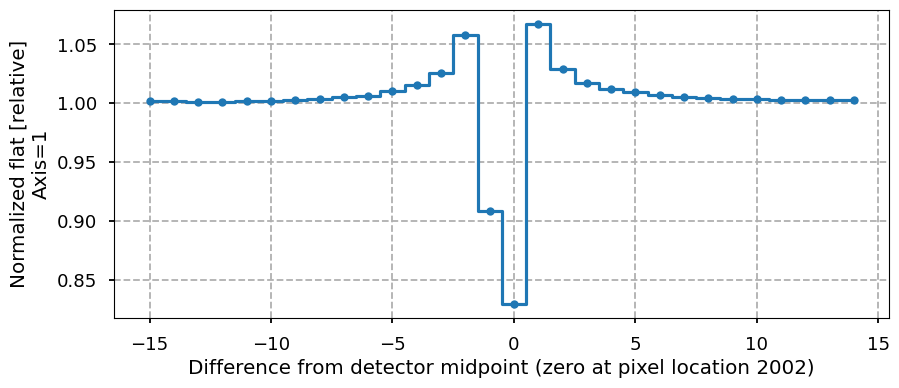

In [15]:
fig,ax = plt.subplots(figsize=[10,4],sharex=True)

window = 15

midpoint = int(len(superNormArr_1)/2)
midArray = edgeArr[midpoint-window:midpoint+window]
ax.step(np.arange(len(midArray))-window,midArray,'-o',where='mid',markersize=6)
ax.grid(ls='--')

# ax.set_ylim(0.99,1.01)

ax.set_xlabel("Difference from detector midpoint (zero at pixel location {})".format(midpoint))
ax.set_ylabel("Normalized flat [relative]\nAxis=1")

### From the above, we know the following
- Roll off response is much stronger in E2V sensors
- Flat field fluctuation is minimized for a border configuration of 5-7 pixels on axis=0 (left/right) and 11-13 pixels on axis=1 (up/down)
  - 7/11 - 9.92545106, 1.84756196 -> 5.89
  - 8/10 - 7.39790545, 2.54627242 -> 4.9715
  - 9/9 - 5.5324111, 3.45451384 -> 4.4949
  - 10/8 - 4.10279525, 4.67511405 -> 4.3899 --> optimal
  - 11/7 - 3.08233591, 6.31235145 -> 4.700
- So the 10/8 configuration performs the best, but only by a tiny margin. The other configurations provide very similar results
- Mid line break impact is ~15% relative at midline location, and is over a larger spatial area. Returns to <1% relative fluctuation after 10 pixels are masked in the region

# Now, do the w_2025_02 weekly

In [30]:
newR7Butler = daf_butler.Butler("/repo/main",collections="u/lsstccs/flat_E1880_w_2025_02")

## ITL detectors first

In [31]:
ITLnormflats = []
for num in ITLnums:
    exp = newR7Butler.get(list(newR7Butler.registry.queryDatasets("flat",where="instrument='LSSTCam' and detector={}".format(num)))[0])
    ITLnormflats.append([np.median(exp.image.array/np.median(exp.image.array),axis=0),np.median(exp.image.array/np.median(exp.image.array),axis=1)])

In [32]:
superNormArr_0 = np.zeros(np.shape(ITLnormflats[0][0]))
superNormArr_1 = np.zeros(np.shape(ITLnormflats[0][1]))
for i,arr in zip(range(2),[superNormArr_0,superNormArr_1]):
    for entry in ITLnormflats:
        arr+=entry[i]
    arr/=len(ITLnormflats)

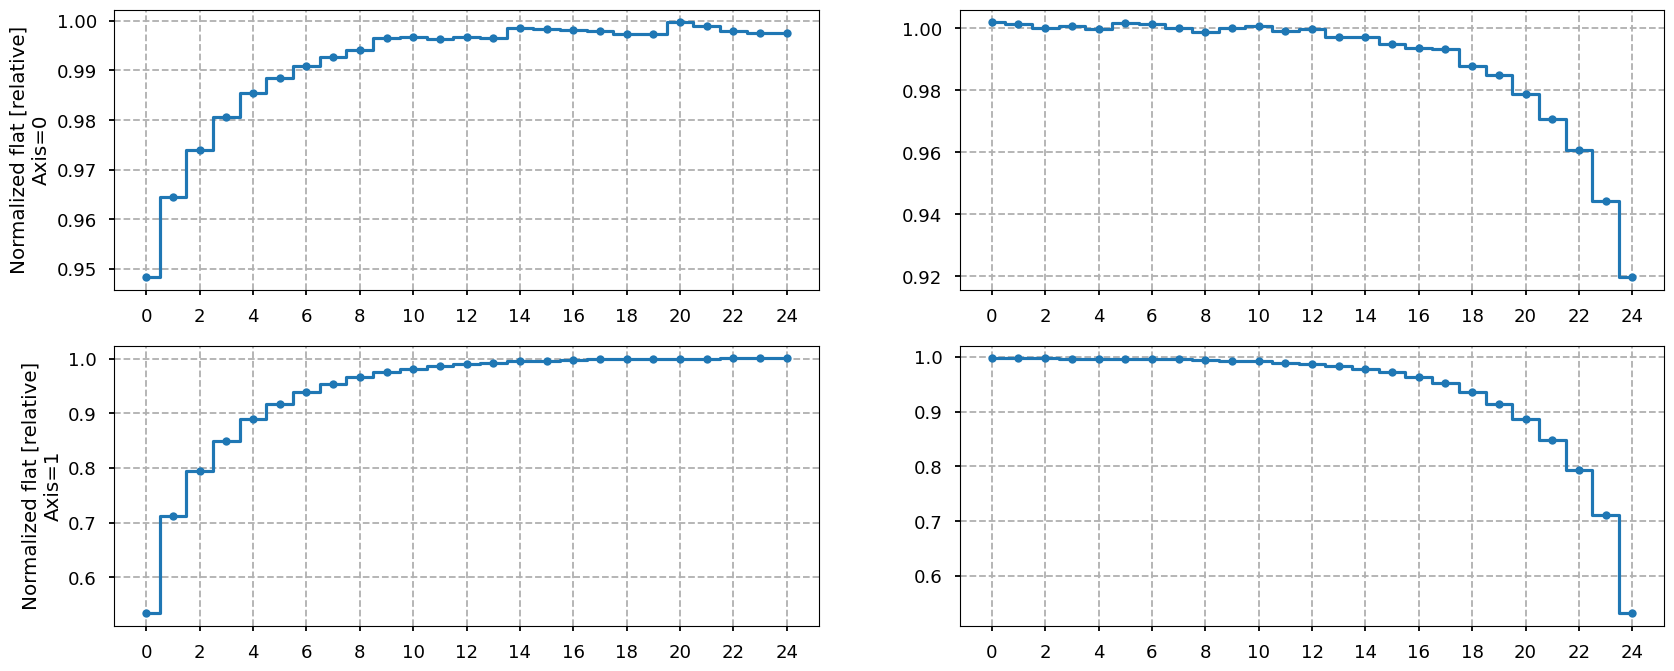

In [33]:
fig,axs = plt.subplots(2,2,figsize=[20,8])

window=25

for edgeArr,ax,counter in zip([superNormArr_0,superNormArr_1],axs,range(2)):
    # print(counter)
    if counter < 1:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=0")
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        ax[0].step(np.arange(window),edgeArr[:window:]/normVal1,'-o',where='mid',markersize=6)
        ax[1].step(np.arange(window),edgeArr[-window::]/normVal2,'-o',where='mid',markersize=6)
        
    else:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=1")
        # No amplifier adjustment

        ax[0].step(np.arange(0,window),edgeArr[:window:],'-o',where='mid',markersize=6)
        ax[1].step(np.arange(0,window),edgeArr[-window::],'-o',where='mid',markersize=6)
    
    
for ax in axs.flatten():
    ax.grid(ls='--')
    # ax.set_ylim(0.95,1)

for ax in axs[1,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))

for ax in axs[0,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))
    # ax.set_ylim(0.95,1.03)


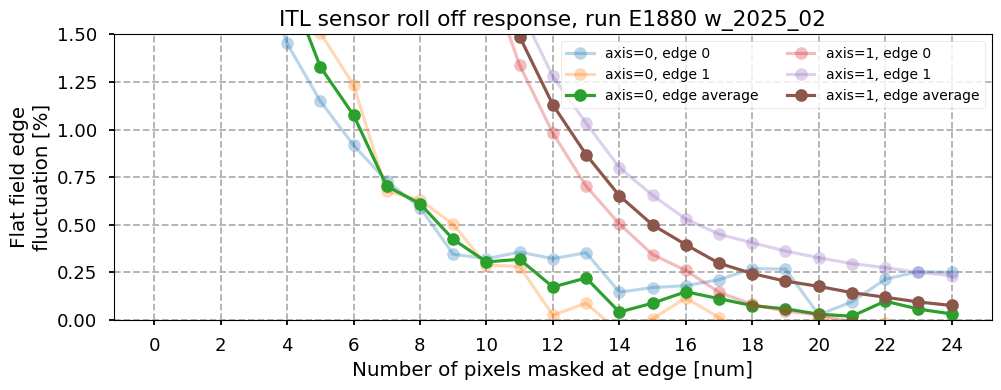

In [38]:
fig,ax = plt.subplots(figsize=[10,4])

window=25

for edgeArr,counter in zip([superNormArr_0,superNormArr_1],range(2)):
    if counter < 1:
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        edge1 = edgeArr[:window:]/normVal1
        edge2 = edgeArr[-window::][::-1]/normVal2

        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,'-o',label="axis=0, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,'-o',label="axis=0, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,'-o',label="axis=0, edge average")
        
        outArr0 = (1-edges)*100
    else:
        # No amplifier adjustment

        edge1 = edgeArr[:window:]
        edge2 = edgeArr[-window::][::-1]
        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,"-o",label="axis=1, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,"-o",label="axis=1, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,"-o",label="axis=1, edge average")
        
        outArr1 = (1-edges)*100
ax.grid(ls='--')
ax.legend(fontsize='medium',ncols=2)

ax.set_xticks(np.arange(0,window+1,step=2))
ax.set_xlabel("Number of pixels masked at edge [num]")

ax.set_ylim(0,1.5)
# ax.set_ylim(0,1.75)

ax.set_ylabel("Flat field edge\nfluctuation [%]")

ax.set_title("ITL sensor roll off response, run E1880 w_2025_02")

fig.tight_layout()

fig.show()

In [39]:
minimizeArray = ((outArr0[:19]+outArr1[:19][::-1])/2)
minInd0 = np.argmin(minimizeArray, axis=0)
minInd1 = 9+(9-minInd0)
print("Optimal configuration to minimize flat field edge fluctuation: {} on ax_0, {} on ax_1".format(minInd0,minInd1))
print("Edge roll off fluctuation: {:2.2f}, {:2.2f}, average {:2.2f}".format(outArr0[minInd0],outArr1[minInd1], np.mean([outArr0[minInd0],outArr1[minInd1]])))

Optimal configuration to minimize flat field edge fluctuation: 7 on ax_0, 11 on ax_1
Edge roll off fluctuation: 0.70, 1.49, average 1.10


Text(0, 0.5, 'Normalized flat [relative]\nAxis=1')

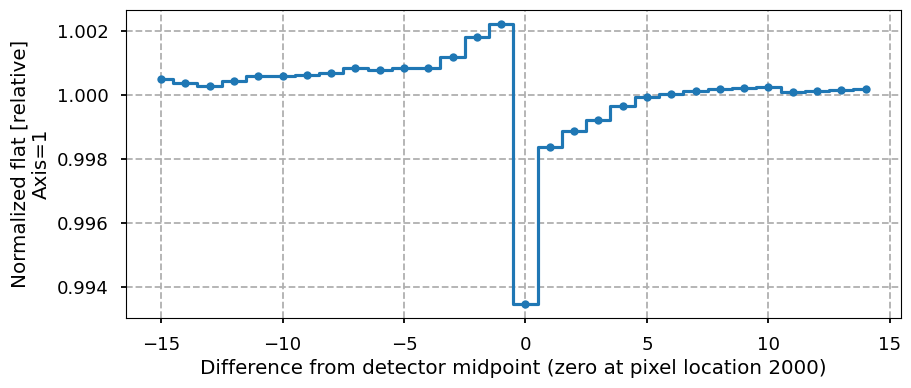

In [40]:
fig,ax = plt.subplots(figsize=[10,4],sharex=True)

window = 15

midpoint = int(len(superNormArr_1)/2)
midArray = edgeArr[midpoint-window:midpoint+window]
ax.step(np.arange(len(midArray))-window,midArray,'-o',where='mid',markersize=6)
ax.grid(ls='--')

ax.set_xlabel("Difference from detector midpoint (zero at pixel location {})".format(midpoint))
ax.set_ylabel("Normalized flat [relative]\nAxis=1")

## E2V detectors now

In [41]:
E2Vnormflats = []
for num in E2Vnums:
    exp = newR7Butler.get(list(newR7Butler.registry.queryDatasets("flat",where="instrument='LSSTCam' and detector={}".format(num)))[0])
    E2Vnormflats.append([np.median(exp.image.array/np.median(exp.image.array),axis=0),np.median(exp.image.array/np.median(exp.image.array),axis=1)])

In [42]:
superNormArr_0 = np.zeros(np.shape(E2Vnormflats[0][0]))
superNormArr_1 = np.zeros(np.shape(E2Vnormflats[0][1]))
for i,arr in zip(range(2),[superNormArr_0,superNormArr_1]):
    for entry in E2Vnormflats:
        arr+=entry[i]
    arr/=len(E2Vnormflats)

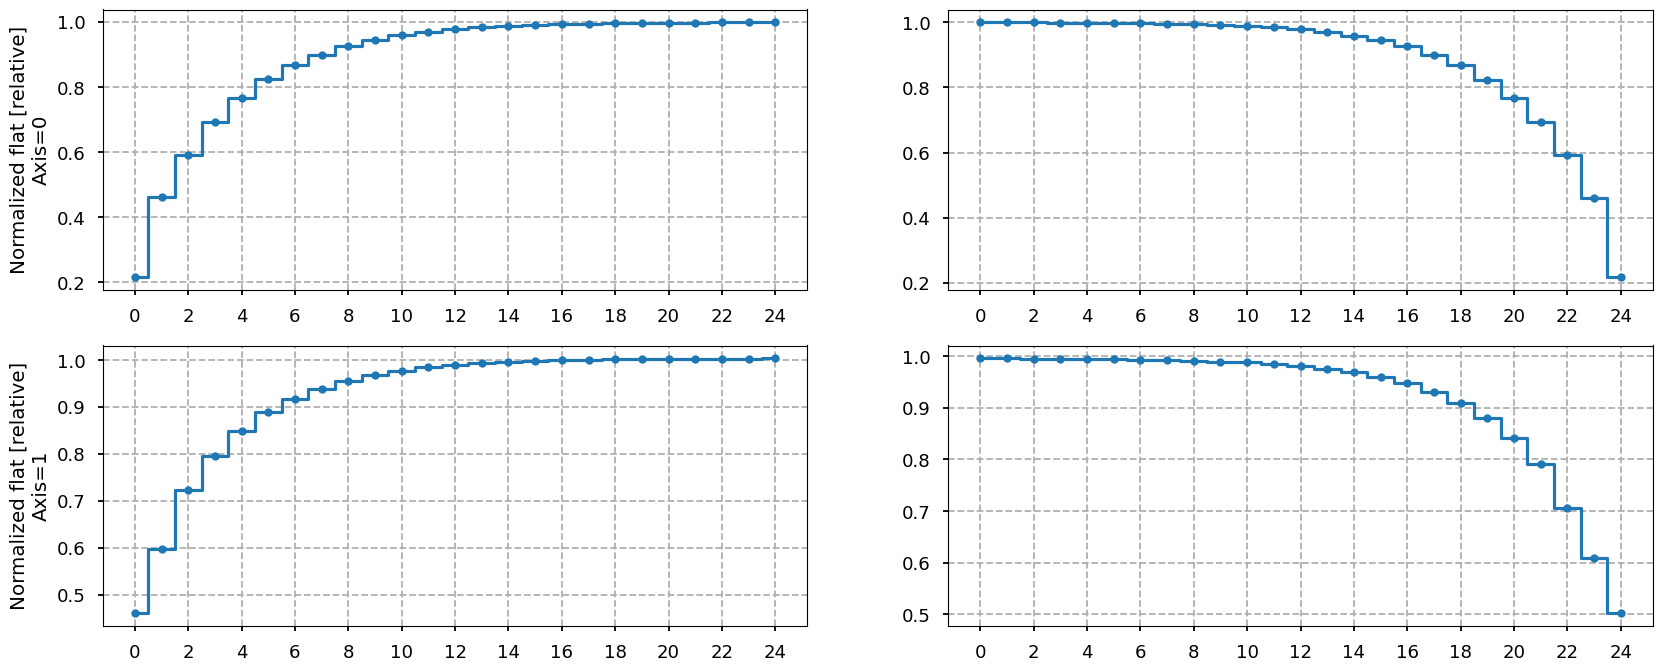

In [43]:
fig,axs = plt.subplots(2,2,figsize=[20,8])

window=25

for edgeArr,ax,counter in zip([superNormArr_0,superNormArr_1],axs,range(2)):
    if counter < 1:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=0")
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        ax[0].step(np.arange(window),edgeArr[:window:]/normVal1,'-o',where='mid',markersize=6)
        ax[1].step(np.arange(window),edgeArr[-window::]/normVal2,'-o',where='mid',markersize=6)
        
    else:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=1")
        # No amplifier adjustment

        ax[0].step(np.arange(0,window),edgeArr[:window:],'-o',where='mid',markersize=6)
        ax[1].step(np.arange(0,window),edgeArr[-window::],'-o',where='mid',markersize=6)
    
    
for ax in axs.flatten():
    ax.grid(ls='--')
    # ax.set_ylim(0.95,1)

for ax in axs[1,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))

for ax in axs[0,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))
    # ax.set_ylim(0.95,1.03)


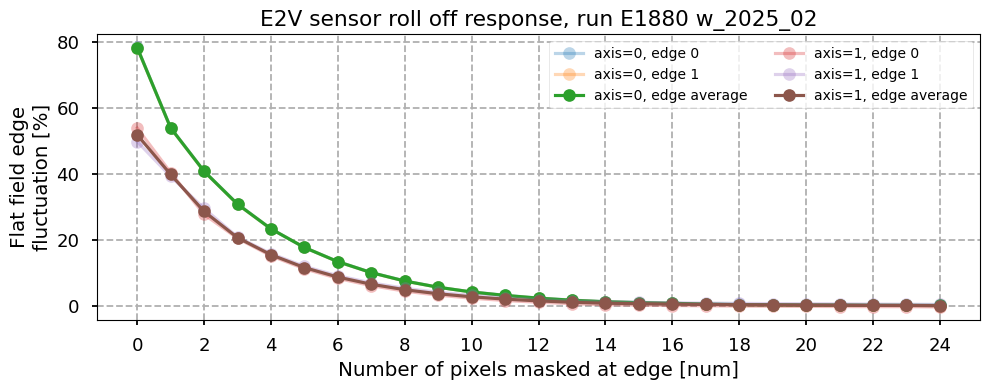

In [49]:
fig,ax = plt.subplots(figsize=[10,4])

window=25

for edgeArr,counter in zip([superNormArr_0,superNormArr_1],range(2)):
    if counter < 1:
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        edge1 = edgeArr[:window:]/normVal1
        edge2 = edgeArr[-window::][::-1]/normVal2

        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,'-o',label="axis=0, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,'-o',label="axis=0, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,'-o',label="axis=0, edge average")
        outArr0 = (1-edges)*100
    else:
        # No amplifier adjustment

        edge1 = edgeArr[:window:]
        edge2 = edgeArr[-window::][::-1]
        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,"-o",label="axis=1, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,"-o",label="axis=1, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,"-o",label="axis=1, edge average")
        outArr1 = (1-edges)*100
ax.grid(ls='--')
ax.legend(fontsize='medium',ncols=2)

ax.set_xticks(np.arange(0,window+1,step=2))
ax.set_xlabel("Number of pixels masked at edge [num]")

# ax.set_ylim(0,10)
# ax.set_xlim(5,20)
# ax.set_ylim(0,1.75)

ax.set_ylabel("Flat field edge\nfluctuation [%]")

ax.set_title("E2V sensor roll off response, run E1880 w_2025_02")

fig.tight_layout()

fig.show()

In [50]:
minimizeArray = ((outArr0[:19]+outArr1[:19][::-1])/2)
minInd0 = np.argmin(minimizeArray, axis=0)
minInd1 = 9+(9-minInd0)
print("Optimal configuration to minimize flat field edge fluctuation: {} on ax_0, {} on ax_1".format(minInd0,minInd1))
print("Edge roll off fluctuation: {:2.2f}, {:2.2f}, average {:2.2f}".format(outArr0[minInd0],outArr1[minInd1], np.mean([outArr0[minInd0],outArr1[minInd1]])))

Optimal configuration to minimize flat field edge fluctuation: 10 on ax_0, 8 on ax_1
Edge roll off fluctuation: 4.15, 4.84, average 4.50


Text(0, 0.5, 'Normalized flat [relative]\nAxis=1')

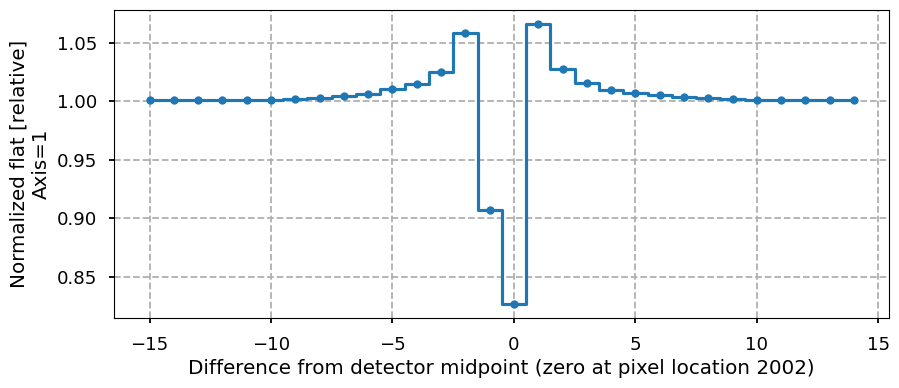

In [51]:
fig,ax = plt.subplots(figsize=[10,4],sharex=True)

window = 15

midpoint = int(len(superNormArr_1)/2)
midArray = edgeArr[midpoint-window:midpoint+window]
ax.step(np.arange(len(midArray))-window,midArray,'-o',where='mid',markersize=6)
ax.grid(ls='--')
# ax.set_ylim(0.99,1.01)
# ax.set_xticks(np.arange(-15,16,step=2))

ax.set_xlabel("Difference from detector midpoint (zero at pixel location {})".format(midpoint))
ax.set_ylabel("Normalized flat [relative]\nAxis=1")

In [29]:
len(np.where(np.abs(1-midArray)>0.01)[0])

9

## From the above, we learn the following
- Axis=1 is taking slices along y in detector space. This is due to the strong mid-line break signal
- Comparing different weekly distributions
    - Difference in masking configuration for ITL sensors, going from 6/12 -> 7/11. ITL edge average decreases from 1.17% -> 1.10%
    - E2V masking configuration does not change. Edge average increases from 4.38% -> 4.50%
- Using the latest weekly 
    - E2V
        - Minimized for a 10/8 masking configuration. 4.50% average response at edges
        - Mid-line break is a ~14% effect at maximum. Returns to <1% of flat field median after 9 pixel region at center
    - ITL
        - Minimized for a 7/11 masking configuration. 1.10% average response at edges
        - Mid-line break is a ~0.7% effect at maximum.

# Now, do `E1110`

In [73]:
newR7Butler_oldV = daf_butler.Butler("embargo_new",collections="u/lsstccs/flat_E1110_w_2024_35")

## ITL detectors first

In [74]:
ITLnormflats = []
for num in ITLnums:
    exp = newR7Butler_oldV.get(list(newR7Butler_oldV.registry.queryDatasets("flat",where="instrument='LSSTCam' and detector={}".format(num)))[0])
    ITLnormflats.append([np.median(exp.image.array/np.median(exp.image.array),axis=0),np.median(exp.image.array/np.median(exp.image.array),axis=1)])

In [75]:
superNormArr_0 = np.zeros(np.shape(ITLnormflats[0][0]))
superNormArr_1 = np.zeros(np.shape(ITLnormflats[0][1]))
for i,arr in zip(range(2),[superNormArr_0,superNormArr_1]):
    for entry in ITLnormflats:
        arr+=entry[i]
    arr/=len(ITLnormflats)

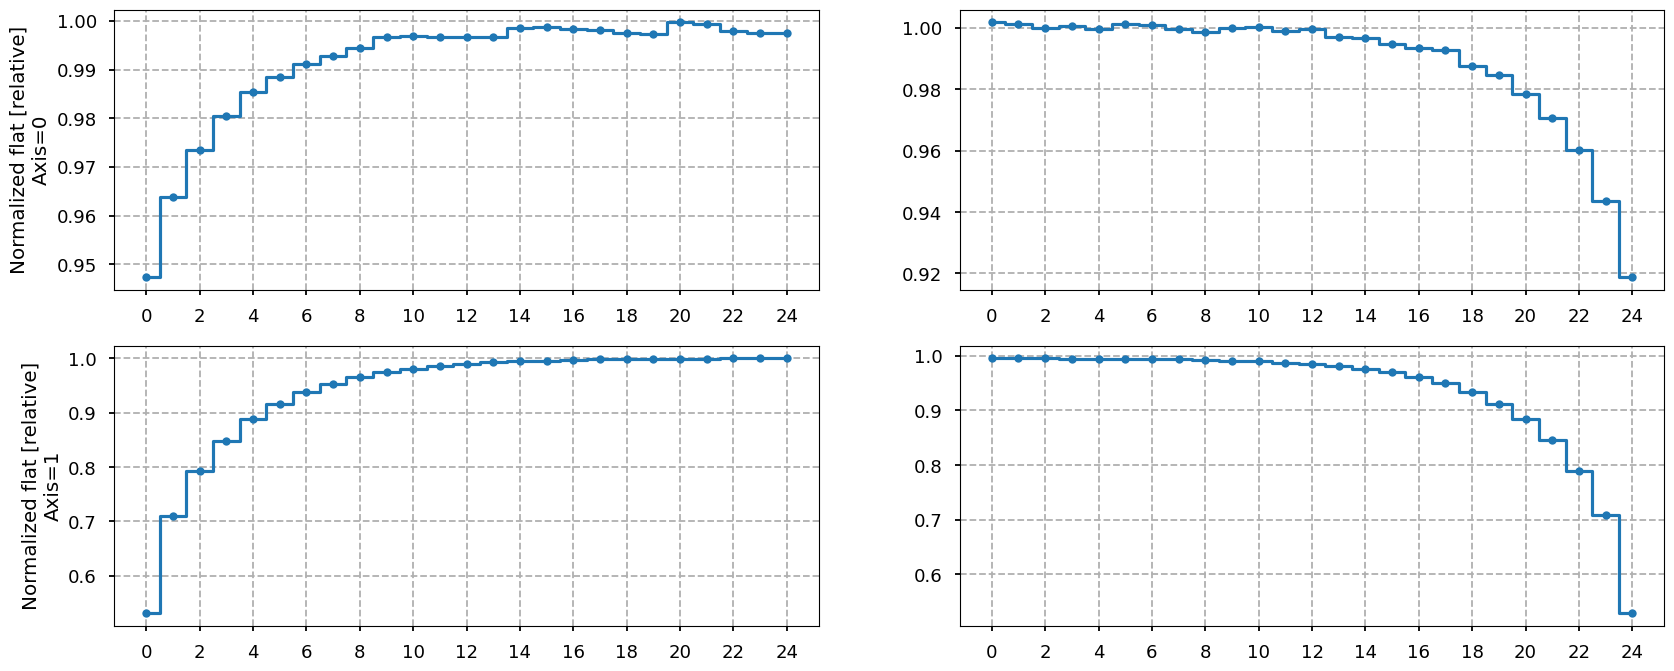

In [76]:
fig,axs = plt.subplots(2,2,figsize=[20,8])

window=25

for edgeArr,ax,counter in zip([superNormArr_0,superNormArr_1],axs,range(2)):
    # print(counter)
    if counter < 1:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=0")
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        ax[0].step(np.arange(window),edgeArr[:window:]/normVal1,'-o',where='mid',markersize=6)
        ax[1].step(np.arange(window),edgeArr[-window::]/normVal2,'-o',where='mid',markersize=6)
        
    else:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=1")
        # No amplifier adjustment

        ax[0].step(np.arange(0,window),edgeArr[:window:],'-o',where='mid',markersize=6)
        ax[1].step(np.arange(0,window),edgeArr[-window::],'-o',where='mid',markersize=6)
    
    
for ax in axs.flatten():
    ax.grid(ls='--')
    # ax.set_ylim(0.95,1)

for ax in axs[1,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))

for ax in axs[0,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))
    # ax.set_ylim(0.95,1.03)


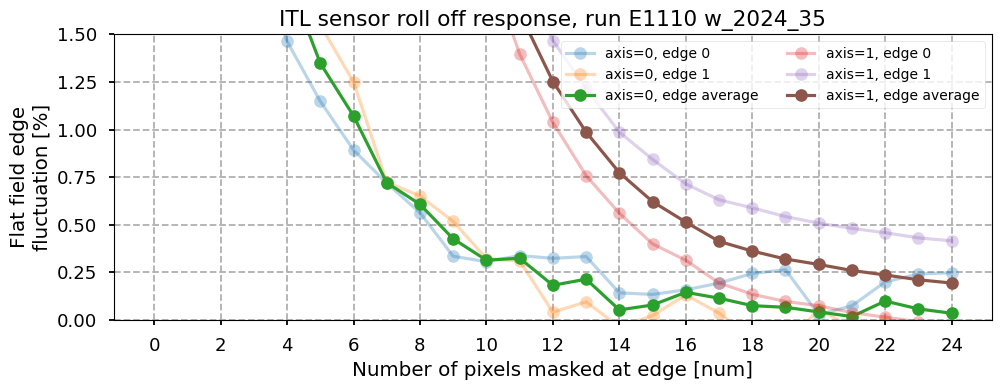

In [77]:
fig,ax = plt.subplots(figsize=[10,4])

window=25

for edgeArr,counter in zip([superNormArr_0,superNormArr_1],range(2)):
    if counter < 1:
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        edge1 = edgeArr[:window:]/normVal1
        edge2 = edgeArr[-window::][::-1]/normVal2

        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,'-o',label="axis=0, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,'-o',label="axis=0, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,'-o',label="axis=0, edge average")
        
        outArr0 = (1-edges)*100
    else:
        # No amplifier adjustment

        edge1 = edgeArr[:window:]
        edge2 = edgeArr[-window::][::-1]
        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,"-o",label="axis=1, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,"-o",label="axis=1, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,"-o",label="axis=1, edge average")
        
        outArr1 = (1-edges)*100
ax.grid(ls='--')
ax.legend(fontsize='medium',ncols=2)

ax.set_xticks(np.arange(0,window+1,step=2))
ax.set_xlabel("Number of pixels masked at edge [num]")

ax.set_ylim(0,1.5)
# ax.set_ylim(0,1.75)

ax.set_ylabel("Flat field edge\nfluctuation [%]")

ax.set_title("ITL sensor roll off response, run E1110 w_2024_35")

fig.tight_layout()

fig.show()

In [78]:
minimizeArray = ((outArr0[:19]+outArr1[:19][::-1])/2)
minInd0 = np.argmin(minimizeArray, axis=0)
minInd1 = 9+(9-minInd0)
print("Optimal configuration to minimize flat field edge fluctuation: {} on ax_0, {} on ax_1".format(minInd0,minInd1))
print("Edge roll off fluctuation: {:2.2f}, {:2.2f}, average {:2.2f}".format(outArr0[minInd0],outArr1[minInd1], np.mean([outArr0[minInd0],outArr1[minInd1]])))

Optimal configuration to minimize flat field edge fluctuation: 6 on ax_0, 12 on ax_1
Edge roll off fluctuation: 1.07, 1.25, average 1.16


Text(0, 0.5, 'Normalized flat [relative]\nAxis=1')

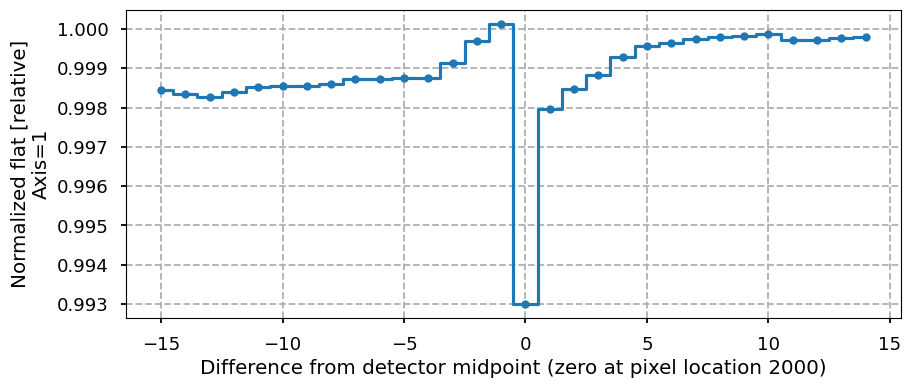

In [79]:
fig,ax = plt.subplots(figsize=[10,4],sharex=True)

window = 15

midpoint = int(len(superNormArr_1)/2)
midArray = edgeArr[midpoint-window:midpoint+window]
ax.step(np.arange(len(midArray))-window,midArray,'-o',where='mid',markersize=6)
ax.grid(ls='--')

ax.set_xlabel("Difference from detector midpoint (zero at pixel location {})".format(midpoint))
ax.set_ylabel("Normalized flat [relative]\nAxis=1")

## E2V detectors now

In [80]:
E2Vnormflats = []
for num in E2Vnums:
    exp = newR7Butler_oldV.get(list(newR7Butler_oldV.registry.queryDatasets("flat",where="instrument='LSSTCam' and detector={}".format(num)))[0])
    E2Vnormflats.append([np.median(exp.image.array/np.median(exp.image.array),axis=0),np.median(exp.image.array/np.median(exp.image.array),axis=1)])

In [81]:
superNormArr_0 = np.zeros(np.shape(E2Vnormflats[0][0]))
superNormArr_1 = np.zeros(np.shape(E2Vnormflats[0][1]))
for i,arr in zip(range(2),[superNormArr_0,superNormArr_1]):
    for entry in E2Vnormflats:
        arr+=entry[i]
    arr/=len(E2Vnormflats)

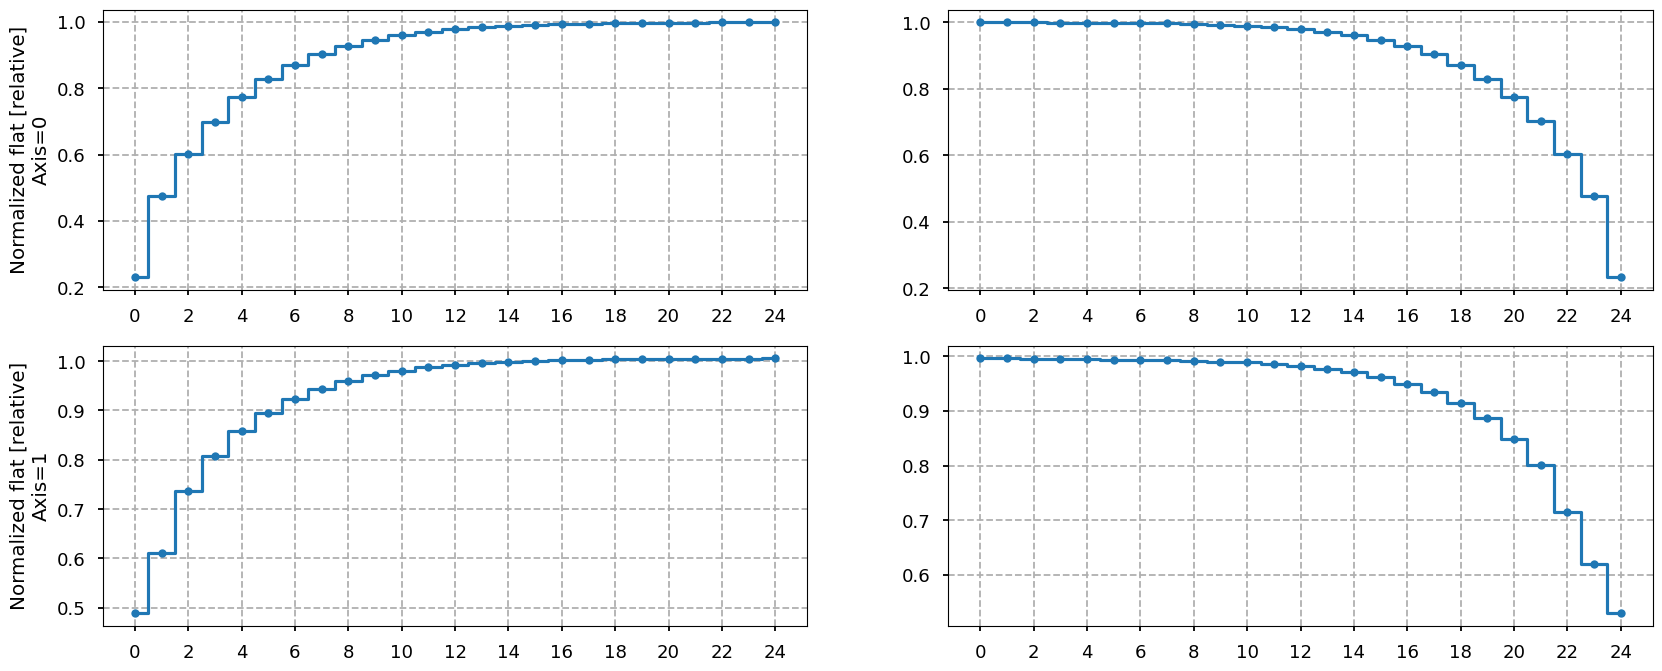

In [82]:
fig,axs = plt.subplots(2,2,figsize=[20,8])

window=25

for edgeArr,ax,counter in zip([superNormArr_0,superNormArr_1],axs,range(2)):
    if counter < 1:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=0")
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        ax[0].step(np.arange(window),edgeArr[:window:]/normVal1,'-o',where='mid',markersize=6)
        ax[1].step(np.arange(window),edgeArr[-window::]/normVal2,'-o',where='mid',markersize=6)
        
    else:
        ax[0].set_ylabel("Normalized flat [relative]\nAxis=1")
        # No amplifier adjustment

        ax[0].step(np.arange(0,window),edgeArr[:window:],'-o',where='mid',markersize=6)
        ax[1].step(np.arange(0,window),edgeArr[-window::],'-o',where='mid',markersize=6)
    
    
for ax in axs.flatten():
    ax.grid(ls='--')
    # ax.set_ylim(0.95,1)

for ax in axs[1,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))

for ax in axs[0,:]:
    ax.set_xticks(np.arange(0,window+1,step=2))
    # ax.set_ylim(0.95,1.03)


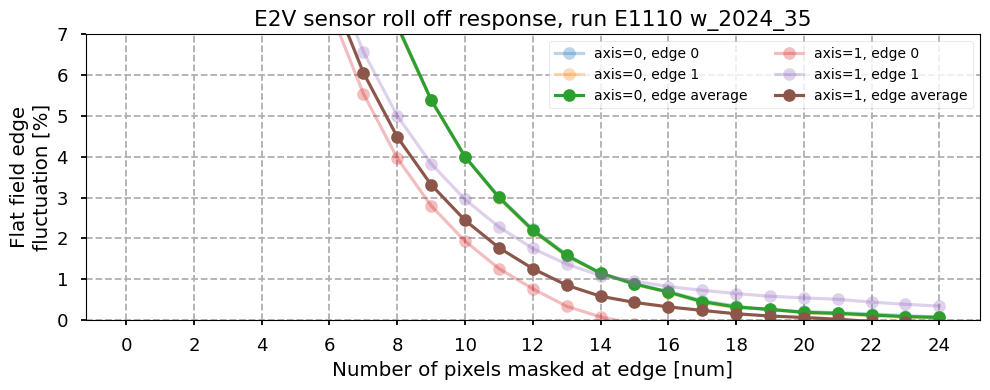

In [87]:
fig,ax = plt.subplots(figsize=[10,4])

window=25

for edgeArr,counter in zip([superNormArr_0,superNormArr_1],range(2)):
    if counter < 1:
        # amplifier adjustment

        normalizedRegion1 = edgeArr[:int(len(superNormArr_0)/8)]
        normVal1 = np.median(normalizedRegion1)
        normalizedRegion2 = edgeArr[-int(len(superNormArr_0)/8):]
        normVal2 = np.median(normalizedRegion2)

        edge1 = edgeArr[:window:]/normVal1
        edge2 = edgeArr[-window::][::-1]/normVal2

        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,'-o',label="axis=0, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,'-o',label="axis=0, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,'-o',label="axis=0, edge average")
        outArr0 = (1-edges)*100
    else:
        # No amplifier adjustment

        edge1 = edgeArr[:window:]
        edge2 = edgeArr[-window::][::-1]
        edges = (edge1 + edge2) / 2

        ax.plot(np.arange(0,len(edges)+0),(1-edge1)*100,"-o",label="axis=1, edge 0",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edge2)*100,"-o",label="axis=1, edge 1",alpha=0.3)
        ax.plot(np.arange(0,len(edges)+0),(1-edges)*100,"-o",label="axis=1, edge average")
        outArr1 = (1-edges)*100
ax.grid(ls='--')
ax.legend(fontsize='medium',ncols=2)

ax.set_xticks(np.arange(0,window+1,step=2))
ax.set_xlabel("Number of pixels masked at edge [num]")

ax.set_ylim(0,7)
# ax.set_xlim(5,20)
# ax.set_ylim(0,1.75)

ax.set_ylabel("Flat field edge\nfluctuation [%]")

ax.set_title("E2V sensor roll off response, run E1110 w_2024_35")

fig.tight_layout()

fig.show()

In [84]:
minimizeArray = ((outArr0[:19]+outArr1[:19][::-1])/2)
minInd0 = np.argmin(minimizeArray, axis=0)
minInd1 = 9+(9-minInd0)
print("Optimal configuration to minimize flat field edge fluctuation: {} on ax_0, {} on ax_1".format(minInd0,minInd1))
print("Edge roll off fluctuation: {:2.2f}, {:2.2f}, average {:2.2f}".format(outArr0[minInd0],outArr1[minInd1], np.mean([outArr0[minInd0],outArr1[minInd1]])))

Optimal configuration to minimize flat field edge fluctuation: 10 on ax_0, 8 on ax_1
Edge roll off fluctuation: 4.00, 4.49, average 4.24


Text(0, 0.5, 'Normalized flat [relative]\nAxis=1')

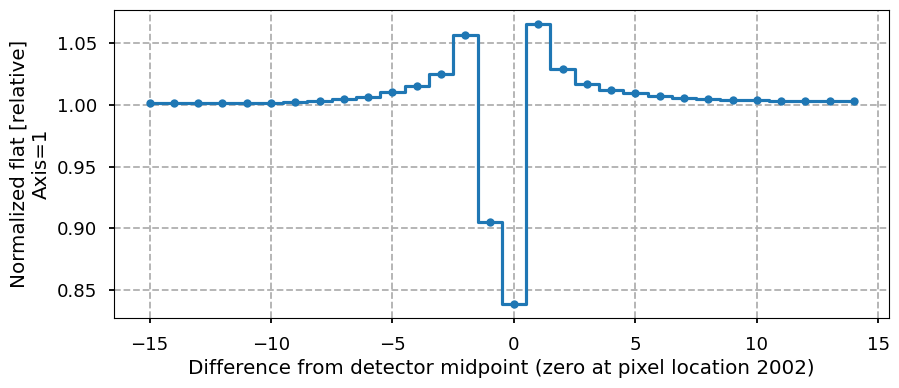

In [85]:
fig,ax = plt.subplots(figsize=[10,4],sharex=True)

window = 15

midpoint = int(len(superNormArr_1)/2)
midArray = edgeArr[midpoint-window:midpoint+window]
ax.step(np.arange(len(midArray))-window,midArray,'-o',where='mid',markersize=6)
ax.grid(ls='--')
# ax.set_ylim(0.99,1.01)
# ax.set_xticks(np.arange(-15,16,step=2))

ax.set_xlabel("Difference from detector midpoint (zero at pixel location {})".format(midpoint))
ax.set_ylabel("Normalized flat [relative]\nAxis=1")

In [86]:
len(np.where(np.abs(1-midArray)>0.01)[0])

10